# Create SAMOS Mask Set 

In [7]:
from pathlib import Path
import numpy as np
from scipy.linalg import hadamard, circulant
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord                           # https://docs.astropy.org/en/stable/coordinates/index.html
import napari

import skimage as ski
ski.io.find_available_plugins()

{'fits': ['imread', 'imread_collection'],
 'gdal': ['imread', 'imread_collection'],
 'gtk': ['imshow'],
 'imageio': ['imread', 'imsave', 'imread_collection'],
 'imread': ['imread', 'imsave', 'imread_collection'],
 'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection'],
 'pil': ['imread', 'imsave', 'imread_collection'],
 'qt': ['imshow', 'imsave', 'imread', 'imread_collection'],
 'simpleitk': ['imread', 'imsave', 'imread_collection'],
 'tifffile': ['imread', 'imsave', 'imread_collection']}

In [5]:
class BinaryMask:
  """Create and manipulate a binary (actually, TRINARY [-1,0,1]) numpy mask.  """

  def __init__(self, arr_size):         #(1024,2048) #(768, 1024) # XGA or DC2K DMD array size
    self.mask = np.zeros(arr_size, dtype=int)
    self.size = arr_size                    # a tuple
    self.x0 = int(self.size[0]/2)           # default mask center is mid-point
    self.y0 = int(self.size[1]/2)           # default mask center is mid-point
    self.center = (self.x0, self.y0)        # format midpoints as a tuple
    self.allowed_values = [-1,0,1]          # enforced by the class; it's actually a TRINARY mask

  def _subarray_insert(self, subarray, x, y):
    """Helper method (private): insert a subarray into a mask, centered at (x,y)"""
    
    # Find "upper left" coordinates (a0,a1) of the insert location      
    row_len = subarray.shape[0]
    col_len = subarray.shape[1]
    a0 = self.x0 - int(row_len/2)
    a1 = self.y0 - int(col_len/2)  

    a0 = x - int(row_len/2)
    a1 = y - int(col_len/2)  
    
    self.mask[a0:a0+row_len, a1:a1+col_len] = subarray         

  def _subarray_expand(self, subarray, n):
      """Helper method (private) to expand a subarray pattern by replicating each pixel n times in both row and column direction"""
      row_len = subarray.shape[0]
      col_len = subarray.shape[1]
      expanded_size = (row_len*n, col_len*n)
      subarray_expanded = np.zeros(expanded_size, dtype='int' )
      
      icount = 0
      for i_order in range (0,row_len):
          row_extract = subarray[i_order,:]            
          row_expand = np.repeat(row_extract, n)    # horizontal expand - replicate "pixels"
          for irow in range(0,n):                   # vertical expand - replicate rows
              subarray_expanded[icount,:] = row_expand
              icount = icount + 1
              
      return subarray_expanded

  def push(self):                                   
     """save a copy of the current mask"""
     self.template = self.mask

  def pop(self):
     """restore the mask to the saved (pushed) version"""
     self.mask = self.template
     
  def reset(self, value = 0):
      """Set all the elements of an existing mask to a single allowed value """

      if any(x == value for x in self.allowed_values): 
          self.mask.fill(value)
      else:  print('.reset(', value, ') not allowed: ')  
  
  def toggle_pix(self, x, y, value = 0):
      """Set a single element of an existing mask to a an allowed value """
      if any(x == value for x in self.allowed_values): 
        self.mask[x,y] = value
      else:  print('.toggle_pix(', value, ') not allowed: ')  
  
  def row_replicate(self, submask, row_n, x, y):
     pass
  
  def insert_submask(self, x, y, submask):
    self._subarray_insert(submask, x,y)

  def insert_Hmatrix(self, x0, y0, order, complement = False):
    H = hadamard(order, dtype= int)
    self._subarray_insert(self, H)
    
  
  def create_Smatrix(self, order,  n_expand = 1):
    allowed_orders = [3,7,11,15,19,23,31,35,43,47,63,71,79,83,103,127,255]

    S_vector = {         
    's3':  [1,0,1],
    's7':  [1,1,1,0,1,0,0],
    's11': [1,1,0,1,1,1,0,0,0,1,0],
    's15': [0,0,0,1,0,0,1,1,0,1,0,1,1,1,1],
    's19': [1,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,1,0],
    's23': [1,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,1,0],
    's31': [0,0,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,0,1],
    's35': [0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1,0,1],
    's43': [1,1,0,0,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0],
    's47': [1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0],
    's63': [0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,0,1,1,1,0,1, \
            1,0,0,1,1,0,1,0,1,0,1,1,1,1,1,1],
    's71': [1,1,1,1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,0,1,0, \
            0,1,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0],
    's79': [1,1,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1, \
            0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0],
    's83': [1,1,0,1,1,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,1,0,0,1,0,0, \
            0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0],
    's103': [1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,1, \
              0,0,1,1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0],
    's127': [0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,1,1,0,1,0,1, \
              0,0,1,1,1,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1, \
              1,0,1,0,0,1,0,1,1,1,0,1,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,1],
    's255': [0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1,0,0,1,1,0,1,1,0,0,0,0,1,1,1,1,0,0, \
              1,1,1,0,0,0,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,1,1,0,1,1, \
              0,1,1,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,1,1,0,0, \
              0,0,0,1,0,0,1,0,1,1,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1, \
              1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,0,1,0, \
              0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,1]}
     
    order_key = 's'+str(order)

    self.S_matrix = np.zeros((order,order), dtype = 'int')
  
    if any(x == order for x in allowed_orders): 
      for i in range(0, order):
        self.S_matrix[i,:]=np.roll(S_vector[order_key],-i)

    else: print('create_Smatrix: order not allowed: ', order)

    # Insert the expanded S-matrix into the mask
    if n_expand != 1: self.S_matrix = self._subarray_expand(self.S_matrix, n_expand)

        
     
  def insert_Smatrix(self, order, x , y, n_expand = 1, circulant = True):
    """Overwrite an S-matrix of specified order, centered at mask position (x,y); expand S-matrix by replicating each pixel n times in both row and column direction """
    allowed_orders = [3,7,11,15,19,23,31,35,43,47,63,71,79,83,103,127,255]
    
    if any(x == order for x in allowed_orders):    # constructs an iterable that yields a sequence of booleans

        if (circulant == True):  # construct the S-matrix from a list of precomputed vectors (Harwit)
            order_key = 's'+str(order)

            S_vector = {         
                's3':  [1,0,1],
                's7':  [1,1,1,0,1,0,0],
                's11': [1,1,0,1,1,1,0,0,0,1,0],
                's15': [0,0,0,1,0,0,1,1,0,1,0,1,1,1,1],
                's19': [1,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,1,0],
                's23': [1,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1,1,0],
                's31': [0,0,0,0,1,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,1,1,1,0,1,0,1],
                's35': [0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1,0,1],
                's43': [1,1,0,0,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0],
                's47': [1,1,1,1,1,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0],
                's63': [0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,1,0,1,0,0,0,1,1,1,0,0,1,0,0,1,0,1,1,0,1,1,1,0,1, \
                        1,0,0,1,1,0,1,0,1,0,1,1,1,1,1,1],
                's71': [1,1,1,1,1,1,1,0,1,1,1,0,1,0,0,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,0,1,0,0,0,1,1,1,0,1,0,0,1,0,1,0, \
                        0,1,1,1,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0],
                's79': [1,1,1,0,1,1,0,0,1,1,1,1,0,1,0,0,1,0,1,1,1,1,1,1,0,1,1,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,1,0,1,1,1, \
                        0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0],
                's83': [1,1,0,1,1,0,0,1,0,1,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,1,0,0,1,0,0, \
                        0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,0,1,0],
                's103': [1,1,1,0,1,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,0,1,0,0,1,0,0,0,0,1, \
                          0,0,1,1,0,1,0,0,1,1,0,1,1,1,1,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,1,1,0,1,0,0],
                's127': [0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,1,1,0,1,0,1, \
                          0,0,1,1,1,1,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,1,1,0,1,1,0,1,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1, \
                          1,0,1,0,0,1,0,1,1,1,0,1,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,1,1,1,1,1,1],
                's255': [0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1,0,0,1,1,0,1,1,0,0,0,0,1,1,1,1,0,0, \
                          1,1,1,0,0,0,0,1,0,1,0,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,1,1,1,0,1,1, \
                          0,1,1,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,1,1,0,0, \
                          0,0,0,1,0,0,1,0,1,1,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,0,1,1,1,1,0,1, \
                          1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,1,1,0,1,0, \
                          0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,1,1,1]
            }

            self.S_matrix = np.zeros((order,order), dtype = 'int')
            
            for i in range(0, order):
                self.S_matrix[i,:]=np.roll(S_vector[order_key],-i)

        else: # circulant not required:  construct the S-matrix from a Hadamard matrix
            H_S = hadamard(order+1, dtype='int')
            H_S = np.delete(H_S, (0), axis = 0)
            H_S = np.delete(H_S, (0), axis = 1)
            H_S[H_S == 1] = 0
            H_S[H_S == -1] = 1

            self.S_matrix = H_S
                
        # Insert the expanded S-matrix into the mask
        if n_expand != 1: self.S_matrix = self._subarray_expand(self.S_matrix, n_expand)
        self._subarray_insert(self.S_matrix, x, y)
        
    else:
        #add error handling; what to set mask to?
        print("order = ", order, " is NOT defined")




## Instantiate a binary mask, add some "static" submasks (slits)   

these will remain unchanged as we create the S-matrix mask set  

NGC3918:  <SkyCoord (ICRS): (ra, dec) in deg
    (177.57404563, -57.18250481)>
11h50m17.77095049s -57d10m57.01730243s
-271.6151052928379 283.6143806704646
823 753
-315.0356052928565 -342.40001453903034
198 709
242.16174201281393 -191.34988879065537
349 1266


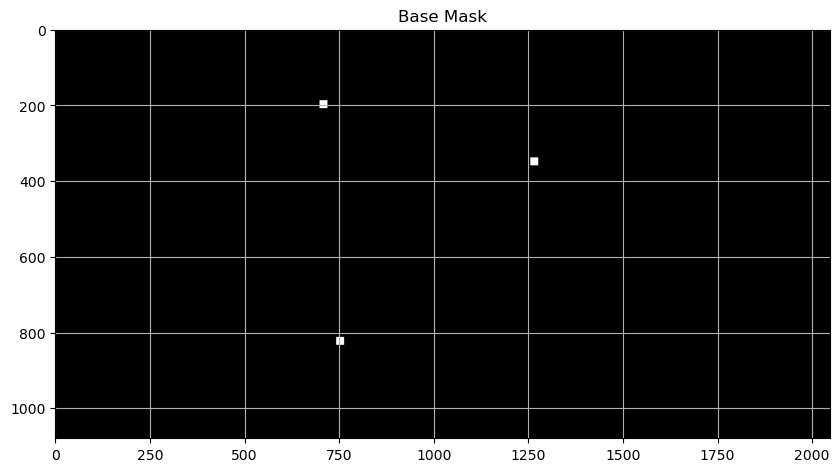

In [11]:
DMD = BinaryMask((1080, 2048))                  # create the empty DMD mask 

n_row = DMD.mask.shape[0]
n_col = DMD.mask.shape[1]

row_center = int(n_row/2)
col_center = int(n_col/2)



c0 = SkyCoord.from_name("NGC3918")  
print('NGC3918: ', c0)
print(c0.to_string('hmsdms'))
c1 = SkyCoord('11:50:20.7949320 -57:11:44.380904', unit=(u.hourangle, u.deg))  # Star 7:00 bottom left
c2 = SkyCoord('11:50:21.2783469 -57:09:59.836500', unit=(u.hourangle, u.deg))  # Star 10:00 top left
c3 = SkyCoord('11:50:15.0748831 -57:10:25.061871', unit=(u.hourangle, u.deg))  # Sky 1:00 top right

mos_mask = np.ones((21,21))
m_scale = 0.167    # arcsec/mirror

#DMD.insert_submask(row_center, col_center, mos_mask)

# FIRST MASK (star)
d_ra = c0.ra.arcsec - c1.ra.arcsec
d_dec = c0.dec.arcsec - c1.dec.arcsec
print(d_ra/m_scale, d_dec/m_scale)

row_mos = row_center + int(d_dec/m_scale)
col_mos = col_center + int(d_ra/m_scale)
print(row_mos, col_mos)
DMD.insert_submask(row_mos, col_mos, mos_mask)

# SECOND MASK (star)
d_ra = c0.ra.arcsec - c2.ra.arcsec
d_dec = c0.dec.arcsec - c2.dec.arcsec
print(d_ra/m_scale, d_dec/m_scale)

row_mos = row_center + int(d_dec/m_scale)
col_mos = col_center + int(d_ra/m_scale)
print(row_mos, col_mos)
DMD.insert_submask(row_mos, col_mos, mos_mask)

# THIRD MASK (sky)
d_ra = c0.ra.arcsec - c3.ra.arcsec
d_dec = c0.dec.arcsec - c3.dec.arcsec
print(d_ra/m_scale, d_dec/m_scale)

row_mos = row_center + int(d_dec/m_scale)
col_mos = col_center + int(d_ra/m_scale)
print(row_mos, col_mos)
DMD.insert_submask(row_mos, col_mos, mos_mask)


#viewer= napari.view_image(DMD.mask, rgb = None, colormap='gray')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.imshow(DMD.mask, cmap='gray'); ax.set_title('Base Mask'); ax.grid()

### Create an S-matrix of order 'n_order` and of unit cell size 'n_cell'.  

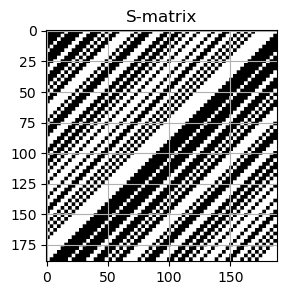

In [61]:
n_cell = 3                                    # keep these explicit for now
n_order = 63                                   # no way to get them programmatically

DMD.create_Smatrix(n_order,n_cell)            # generate an S-matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.imshow(DMD.S_matrix, cmap='gray'); ax.set_title('S-matrix'); ax.grid()

### Take each row of the S-matrix and replicate it into a set of  submasks  

In [62]:
submask_rows = 300                                                          # the number of columns is fixed, but the number of rows is arbitrary
submask_cols = DMD.S_matrix.shape[1]
submask_arr = np.zeros((submask_rows, submask_cols, n_order), dtype = 'int')    # the array of row-replicated S-matrices

row_select = np.arange(0, DMD.S_matrix.shape[0], n_cell)                                 # skip redundant rows (a conseqence of n_cell > 1)

i = 0
for row in row_select:
    row_out = DMD.S_matrix[row,:]                                         # extract row from the S-matrix
    submask_cols = row_out.shape[0]
    #print(submask_cols)
    grid_arr = np.broadcast_to(row_out, (submask_rows, submask_cols))                # replicate the row into a 2d array
    submask_arr[:,:,i] = grid_arr
    i = i + 1

# viewer = napari.view_image(submask_arr, rgb = None, colormap='gray')

### Insert each submask into a copy of the overall binary mask - creating a set of masks with the row-replicated S-matrix in each one

In [63]:
n_row = DMD.mask.shape[0]
n_col = DMD.mask.shape[1]

mask_arr = np.zeros((n_row,n_col,n_order))

DMD.push                         # save a copy of the base mask

row_center = int(n_row/2)
col_center = int(n_col/2)

for n_mask in range(n_order):
    DMD.pop
    DMD.insert_submask(int(n_row/2), int(n_col/2), submask_arr[:,:,n_mask])
    mask_arr[:, :, n_mask] = DMD.mask

viewer= napari.view_image(mask_arr, rgb = None, colormap='gray')


### Write the mask file sequence to disk as bitmap files

In [65]:
from PIL import Image as im
cwd = Path.cwd()
target_dir = Path.cwd() / "HTSI_masks"

for n_mask in range(n_order):
    im_out = mask_arr[:, :, n_mask]*255
    im_data = im.fromarray((im_out).astype(np.uint8))
    fname = 'NGC3918_S63_' + str(n_mask) + '.bmp'
    full_path = target_dir / fname
    im_data.save(full_path)

In [8]:
from astropy import units as u
from astropy.coordinates import SkyCoord                           # https://docs.astropy.org/en/stable/coordinates/index.html
c = SkyCoord(ra=10.625*u.degree, dec=41.2*u.degree, frame='icrs')

In [35]:
# Pull coordinates from Aladin Lite.  Zoom to 3.087x2.219'

c0 = SkyCoord.from_name("NGC3918")  
c1 = SkyCoord('11:50:20.7949320 -57:11:44.380904', unit=(u.hourangle, u.deg))  # Star 7:00 bottom left
c2 = SkyCoord('11:50:21.2783469 -57:09:59.836500', unit=(u.hourangle, u.deg))  # Star 10:00 top left
c3 = SkyCoord('11:50:15.0748831 -57:10:25.061871', unit=(u.hourangle, u.deg))  # Sky 1:00 top right
print(c0,c1,c2,c3)

#11:50:20.7949320 -57:11:44.380904   
# 11:50:21.2783469 -57:09:59.836500    
# 11:50:15.0748831 -57:10:25.061871 

m_scale = 0.167    # arcsec/mirror

d_ra = c0.ra.arcsec -c1.ra.arcsec
d_dec = c0.dec.arcsec -c1.dec.arcsec
print(d_ra, d_dec)
print(d_ra/m_scale, d_dec/m_scale)



<SkyCoord (ICRS): (ra, dec) in deg
    (177.57404563, -57.18250481)> <SkyCoord (ICRS): (ra, dec) in deg
    (177.58664555, -57.19566136)> <SkyCoord (ICRS): (ra, dec) in deg
    (177.58865978, -57.16662125)> <SkyCoord (ICRS): (ra, dec) in deg
    (177.56281201, -57.1736283)>
-45.35972258390393 47.36360157196759
-271.6151052928379 283.6143806704646
